# Классификация дорожных знаков

# Анализ данных


In [12]:
from __future__ import print_function, division

import os
import cv2
import glob
import time
import json
import torch
import torchvision

import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.image as mpimg

from tqdm import tqdm
from pathlib import Path
from skimage.io import imread
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms

%matplotlib inline
plt.ion()

### Для начала создадим pandas dataframe из тренировочных данных

In [13]:
data_dir = '/home/maxim/Projects/Datasets/nkb/traffic_sign'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

# target names
images = { 
'00' : train_dir + '/00',
'01' : train_dir + '/01',
'02' : train_dir + '/02',
'03' : train_dir + '/03',
'04' : train_dir + '/04',
'05' : train_dir + '/05',
'06' : train_dir + '/06',
'07' : train_dir + '/07',
'08' : train_dir + '/08',
'09' : train_dir + '/09',
'10' : train_dir + '/10',
'11' : train_dir + '/11',
'12' : train_dir + '/12',
'13' : train_dir + '/13',
'14' : train_dir + '/14',
'15' : train_dir + '/15',
'16' : train_dir + '/16',
'17' : train_dir + '/17',
'18' : train_dir + '/18',
'19' : train_dir + '/19',
'20' : train_dir + '/20',
'21' : train_dir + '/21',
'22' : train_dir + '/22',
'23' : train_dir + '/23',
'24' : train_dir + '/24',
'25' : train_dir + '/25',
'26' : train_dir + '/26',
'27' : train_dir + '/27',
'28' : train_dir + '/28',
'29' : train_dir + '/29',
'30' : train_dir + '/30',
'31' : train_dir + '/31',
'32' : train_dir + '/32',
'33' : train_dir + '/33',
'34' : train_dir + '/34',
'35' : train_dir + '/35',
'36' : train_dir + '/36',
'37' : train_dir + '/37'
}

train_data_list = []
for k in images.keys():
    for dirname, _, filenames in os.walk('/home/maxim/Projects/Datasets/nkb/traffic_sign/train/' + k):
        for filename in filenames:
            train_data_list.append((os.path.join(dirname, filename),k))
            
train_data = pd.DataFrame(train_data_list, columns=['image', 'label'],index=None)

### Мы имееем датасет, который состоит из 38 классов. При чем один из классов - отсутствие дорожных знаков, а другой - дорожные знаки, которые не попали в отдельный класс.

In [14]:
train_data

image label
0       /home/maxim/Projects/Datasets/nkb/traffic_sign...    00
1       /home/maxim/Projects/Datasets/nkb/traffic_sign...    00
2       /home/maxim/Projects/Datasets/nkb/traffic_sign...    00
3       /home/maxim/Projects/Datasets/nkb/traffic_sign...    00
4       /home/maxim/Projects/Datasets/nkb/traffic_sign...    00
...                                                   ...   ...
122289  /home/maxim/Projects/Datasets/nkb/traffic_sign...    37
122290  /home/maxim/Projects/Datasets/nkb/traffic_sign...    37
122291  /home/maxim/Projects/Datasets/nkb/traffic_sign...    37
122292  /home/maxim/Projects/Datasets/nkb/traffic_sign...    37
122293  /home/maxim/Projects/Datasets/nkb/traffic_sign...    37

[122294 rows x 2 columns]

In [15]:
#train_data.to_csv('/home/maxim/Projects/Datasets/nkb/traffic_sign/train_data.csv', index=False)

### Как видно на графике, выборка является несбалансированной. Очевидно, что самыми большими классами являются - "Other" и "No Sign". Однако, третий по численности класс превышает последний в 13 раз. 

09    25787
10    11304
02     7612
11     6528
00     4746
18     4011
17     3819
20     3716
04     3654
16     3385
21     3274
19     3151
08     2923
03     2912
01     2761
22     2738
06     2427
05     2057
13     2014
31     1649
28     1637
27     1636
29     1616
32     1598
12     1557
30     1554
07     1418
23     1294
25     1240
26     1163
14     1088
15      991
24      946
33      883
37      882
36      878
35      877
34      568
Name: label, dtype: int64


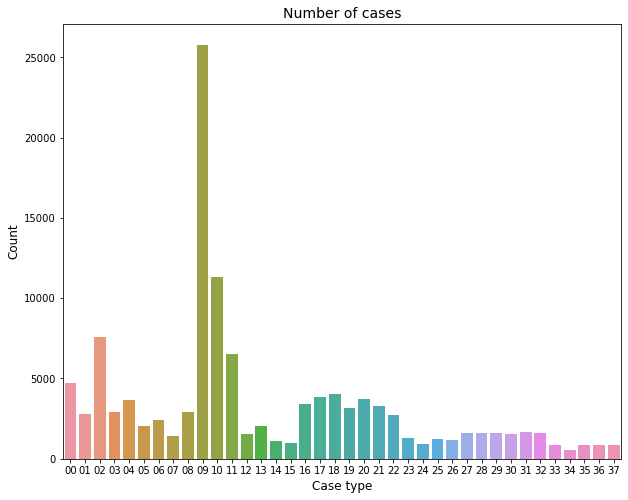

In [16]:
cases_count = train_data['label'].value_counts()
print(cases_count)

plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

### Изображения в наборе данных имеют разный размер. Встречаются различные размеры от примерно 15x15, до 135x135

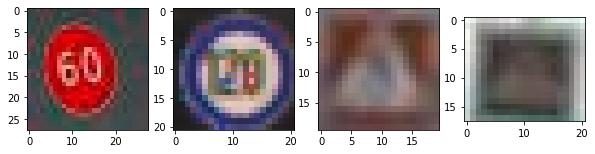

In [17]:
train_data_sample = train_data.sample(frac=1.).reset_index(drop=True)
image_0 = cv2.imread(train_data_sample['image'][0]) 
image_1 = cv2.imread(train_data_sample['image'][1]) 
image_2 = cv2.imread(train_data_sample['image'][2]) 
image_3 = cv2.imread(train_data_sample['image'][3]) 
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10)) 
ax[0].imshow(image_0)
ax[1].imshow(image_1)
ax[2].imshow(image_2)
ax[3].imshow(image_3)

# Подготовка данных

### Создаем загрузчик данных для тренировочной выборки и тестовой. Валидационная выборка не создается.

In [18]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
    ]),
    'test': transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
        
    ]),
}

data_dir = '/home/maxim/Projects/Datasets/nkb/traffic_sign'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=12)
              for x in ['train', 'test']}
               
dataset_sizes_train = len(image_datasets['train'])
dataset_sizes_test = len(image_datasets['test'])

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Обучение модели

### В качестве архитектуры используется совокупность CNN and Spatial transformer network

In [19]:
nclasses = 38 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(3, 100, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(100)
        self.conv2 = nn.Conv2d(100, 150, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(250)
        self.conv_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(250*2*2, 350)
        self.fc2 = nn.Linear(350, nclasses)

        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
            )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
            )
   
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))


    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform forward pass
        x = self.bn1(F.max_pool2d(F.leaky_relu(self.conv1(x)),2))
        x = self.conv_drop(x)
        x = self.bn2(F.max_pool2d(F.leaky_relu(self.conv2(x)),2))
        x = self.conv_drop(x)
        x = self.bn3(F.max_pool2d(F.leaky_relu(self.conv3(x)),2))
        x = self.conv_drop(x)
        x = x.view(-1, 250*2*2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [20]:
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        epoch_loss_train = 0.0
        epoch_loss_test = 0.0
        epoch_acc_train = 0.0
        epoch_acc_test = 0.0
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss_train = 0.0
            running_corrects_train = 0
            running_loss_test = 0.0
            running_corrects_test = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc='Training...'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                if phase == 'train':
                    running_loss_train += loss.item() * inputs.size(0)
                    running_corrects_train += torch.sum(preds == labels.data)
                
                if phase == 'test':
                    running_loss_test += loss.item() * inputs.size(0)
                    running_corrects_test += torch.sum(preds == labels.data)

            if phase == 'train':
                epoch_loss_train = running_loss_train / dataset_sizes_train
                epoch_acc_train = running_corrects_train.double() / dataset_sizes_train
            
            if phase == 'test':
                epoch_loss_test = running_loss_test / dataset_sizes_test
                epoch_acc_test = running_corrects_test.double() / dataset_sizes_test

            if phase == 'train':
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss_train, epoch_acc_train))
                
            if phase == 'test':
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss_test, epoch_acc_test))

            # Save best model
            if phase == 'test' and epoch_acc_test > best_acc:
                best_acc = epoch_acc_test
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss_test,
                    'accuracy': epoch_acc_test
                }, os.path.join('/home/maxim/Projects/nkb_test/best_model', 'best_model.pth'))

                    
        writer.add_scalars('Loss', {'train': epoch_loss_train,
                                    'test': epoch_loss_test}, epoch)
            
        writer.add_scalars('Accuracy', {'train': epoch_acc_train,
                                    'test': epoch_acc_test}, epoch)
        writer.flush()
        
        # Save current model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss_test,
            'accuracy': epoch_acc_test
        }, os.path.join('/home/maxim/Projects/nkb_test/current_model', 'current_model.pth'))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return model

In [21]:
writer = SummaryWriter('/home/maxim/Projects/nkb_test/runs')
model_conv = Net()
model_conv = model_conv.to(device)
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.0001)
criterion = F.nll_loss

In [18]:
model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=1000)

Training...:   0%|          | 0/956 [00:00<?, ?it/s]

Epoch 0/999
----------


/home/maxim/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/maxim/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
Training...:   6%|▌         | 53/956 [00:02<00:32, 28.20it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 1.6838 Acc: 0.5162


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.6861 Acc: 0.8169

Epoch 1/999
----------


Training...:   0%|          | 1/956 [00:00<07:13,  2.20it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.6304 Acc: 0.8026


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.2621 Acc: 0.9326

Epoch 2/999
----------


Training...:  69%|██████▉   | 664/956 [00:24<00:10, 28.59it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.3234 Acc: 0.9039


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.1488 Acc: 0.9598

Epoch 3/999
----------


Training...:  44%|████▍     | 424/956 [00:15<00:18, 28.62it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.2179 Acc: 0.9392


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.1136 Acc: 0.9670

Epoch 4/999
----------


Training...:  25%|██▌       | 243/956 [00:08<00:29, 24.50it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.1694 Acc: 0.9533


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0930 Acc: 0.9729

Epoch 5/999
----------


Training...:  54%|█████▍    | 515/956 [00:17<00:15, 29.15it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.1418 Acc: 0.9607


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0789 Acc: 0.9768

Epoch 6/999
----------


Training...:  53%|█████▎    | 504/956 [00:18<00:15, 28.92it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.1245 Acc: 0.9647


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0677 Acc: 0.9807

Epoch 7/999
----------


Training...:   8%|▊         | 81/956 [00:03<00:29, 29.27it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.1101 Acc: 0.9694


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0636 Acc: 0.9822

Epoch 8/999
----------


Training...:  37%|███▋      | 351/956 [00:12<00:20, 29.15it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.1007 Acc: 0.9721


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0585 Acc: 0.9833

Epoch 9/999
----------


Training...:  15%|█▌        | 145/956 [00:05<00:27, 29.20it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.0903 Acc: 0.9745


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0511 Acc: 0.9852

Epoch 10/999
----------


Training...:  88%|████████▊ | 846/956 [00:29<00:03, 29.27it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.0838 Acc: 0.9764


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0487 Acc: 0.9864

Epoch 11/999
----------


Training...:  19%|█▉        | 186/956 [00:06<00:26, 29.18it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.0802 Acc: 0.9772


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0417 Acc: 0.9879

Epoch 12/999
----------


Training...:   1%|▏         | 13/956 [00:00<01:53,  8.31it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.0740 Acc: 0.9789


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0433 Acc: 0.9873

Epoch 13/999
----------


Training...:  43%|████▎     | 408/956 [00:15<00:19, 28.58it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.0709 Acc: 0.9800


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0409 Acc: 0.9878

Epoch 14/999
----------


Training...:   2%|▏         | 16/956 [00:00<01:33, 10.09it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.0669 Acc: 0.9805


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0392 Acc: 0.9896

Epoch 15/999
----------


Training...:  26%|██▌       | 245/956 [00:08<00:24, 29.09it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.0634 Acc: 0.9813


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0384 Acc: 0.9895

Epoch 16/999
----------


Training...:  49%|████▉     | 472/956 [00:16<00:16, 28.82it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.0599 Acc: 0.9825


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0347 Acc: 0.9902

Epoch 17/999
----------


Training...:  45%|████▍     | 427/956 [00:15<00:18, 29.28it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.0589 Acc: 0.9828


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0373 Acc: 0.9894

Epoch 18/999
----------


Training...:   0%|          | 1/956 [00:00<07:13,  2.20it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:   0%|          | 0/133 [00:00<?, ?it/s]

train Loss: 0.0561 Acc: 0.9841


Training...:   0%|          | 0/956 [00:00<?, ?it/s]

test Loss: 0.0337 Acc: 0.9908

Epoch 19/999
----------


Training...:  13%|█▎        | 123/956 [00:05<00:29, 28.16it/s]/home/maxim/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Training...:  19%|█▉        | 180/956 [00:07<00:31, 24.86it/s]


KeyboardInterrupt: 

# Демо версия

### Демо версия берет 4 случайных изображения из тестовой выборки. Нейросеть предсказывает класс. Вместо класса подставляется значение ГОСТ из json файла.

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.3337, 0.3064, 0.3171])
    std = np.array([0.2672, 0.2564, 0.2629])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
    
def sign_values(value):
    with open('/home/maxim/Projects/nkb_test/Info.json') as f:
        templates = json.load(f)
        sign_dict = dict(templates)
        for k, v in sign_dict.items():
            if v == value:
                return k
            
            
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(sign_values(class_names[preds[j]])))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [23]:
best_model = Net()
best_model = best_model.to(device)
checkpoint = torch.load('/home/maxim/Projects/nkb_test/best_model/best_model.pth')
best_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

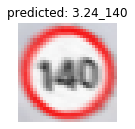

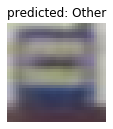

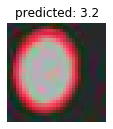

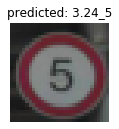

In [26]:
visualize_model(best_model)

plt.ioff()
plt.show()